# Exploratory Data Analysis - YouTube Spam Detection

This notebook performs a basic exploratory data analysis on the YouTube Spam Collection dataset.


## Setup and loading


In [1]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from spam_ham_detector.config import INTERIM_DATA_DIR


In [2]:
# Load the dataset
data_path = INTERIM_DATA_DIR / 'comments.csv'

# Count total rows in CSV file
with open(data_path, encoding='utf-8') as f:
    csv_total_rows = sum(1 for _ in f) - 1

df = pd.read_csv(data_path)
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


## Data Overview


### Dataset Information


In [3]:
# Basic statistics
print('Dataset Shape:', df.shape)
print('Column Names:', df.columns.tolist())

df['CLASS'].value_counts()

Dataset Shape: (1956, 5)
Column Names: ['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS']


CLASS
1    1005
0     951
Name: count, dtype: int64

In [4]:
# Data Loading Report
print('Data Loading Report:')
print(f'- CSV file rows (excluding header): {csv_total_rows}')
print(f'- DataFrame rows loaded: {len(df)}')
print(f'- Rows lost during loading: {csv_total_rows - len(df)}')
print()

if len(df) < csv_total_rows:
    print(f'Note: {csv_total_rows - len(df)} rows (~{((csv_total_rows - len(df))/csv_total_rows)*100:.2f}%) were dropped during CSV parsing')
    print('Likely cause: Malformed CSV rows, encoding issues, or parsing errors. Consider reviewing the CSV file for inconsistencies.')

Data Loading Report:
- CSV file rows (excluding header): 1961
- DataFrame rows loaded: 1956
- Rows lost during loading: 5

Note: 5 rows (~0.25%) were dropped during CSV parsing
Likely cause: Malformed CSV rows, encoding issues, or parsing errors. Consider reviewing the CSV file for inconsistencies.


### Data Quality


In [5]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})

,Missing Count,Percentage
COMMENT_ID,0,0.000000
AUTHOR,0,0.000000
DATE,245,12.525562
CONTENT,0,0.000000
CLASS,0,0.000000


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f'Duplicate rows: {duplicates}')

# Check for duplicate comments (same content)
duplicate_content = df['CONTENT'].duplicated().sum()
print(f'Duplicate comments (same content): {duplicate_content}')

Duplicate rows: 3
Duplicate comments (same content): 196


In [7]:
# Duplicate Analysis
print('Duplicate Analysis:')
print(f'- Exact duplicates: {duplicates} rows')
print(f'- Content duplicates: {duplicate_content} comments')
print()

print('Note: Duplicates kept for EDA. Consider removal before modeling')

Duplicate Analysis:
- Exact duplicates: 3 rows
- Content duplicates: 196 comments

Note: Duplicates kept for EDA. Consider removal before modeling


## Target Variable Analysis


### Class distribution


In [8]:
# Class distribution
class_counts = df['CLASS'].value_counts()
class_pct = df['CLASS'].value_counts(normalize=True) * 100

pd.DataFrame({'Count': class_counts, 'Percentage': class_pct})

,Count,Percentage
CLASS,,
1,1005,51.380368
0,951,48.619632


## Feature Engineering


### Text Features


In [9]:
# Create text-based features
df['text_length'] = df['CONTENT'].str.len()
df['word_count'] = df['CONTENT'].str.split().str.len()

df[['CONTENT', 'text_length', 'word_count']].head()

,CONTENT,text_length,word_count
0,"Huh, anyway check out this you[tube] channel: ...",56,8
1,Hey guys check out my new channel and our firs...,166,30
2,just for test I have to say murdev.com,38,8
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,48,11
4,watch?v=vtaRGgvGtWQ Check this out .﻿,39,5


### Statistical Comparison by Class


In [10]:
# Compare text features between spam and ham
stats_by_class = df.groupby('CLASS')[['text_length', 'word_count']].agg(['mean', 'median', 'std'])

stats_by_class.index = stats_by_class.index.map({0: 'Ham', 1: 'Spam'})
stats_by_class.round(2)

text_length                word_count              
             mean median     std       mean median    std
CLASS                                                    
Ham         49.64   34.0   56.28       9.10    6.0  10.43
Spam       137.34   65.0  158.98      21.71   10.0  26.88

In [11]:
# Percentile Analysis - Text Length
print('Percentile Analysis - Text Length:')
for idx, cls_name in [(0, 'Ham'), (1, 'Spam')]:
    data = df[df['CLASS'] == idx]['text_length']
    print(f'{cls_name}:')
    print(f'  25th percentile: {data.quantile(0.25)}')
    print(f'  50th percentile: {data.quantile(0.50)}')
    print(f'  75th percentile: {data.quantile(0.75)}')
    print(f'  Maximum: {data.max()}')
    print()

# Show examples of extreme values
print('Extreme Length Examples:')
extreme_spam = df[(df['CLASS'] == 1) & (df['text_length'] > df[df['CLASS']==1]['text_length'].quantile(0.99))]
print(f'Top 1% longest spam comments: {len(extreme_spam)} examples')
print(f'Length range: {extreme_spam["text_length"].min()} - {extreme_spam["text_length"].max()} characters')

Percentile Analysis - Text Length:
Ham:
  25th percentile: 18.0
  50th percentile: 34.0
  75th percentile: 62.0
  Maximum: 753

Spam:
  25th percentile: 36.0
  50th percentile: 65.0
  75th percentile: 171.0
  Maximum: 1200

Extreme Length Examples:
Top 1% longest spam comments: 11 examples
Length range: 575 - 1200 characters


### Visualizations


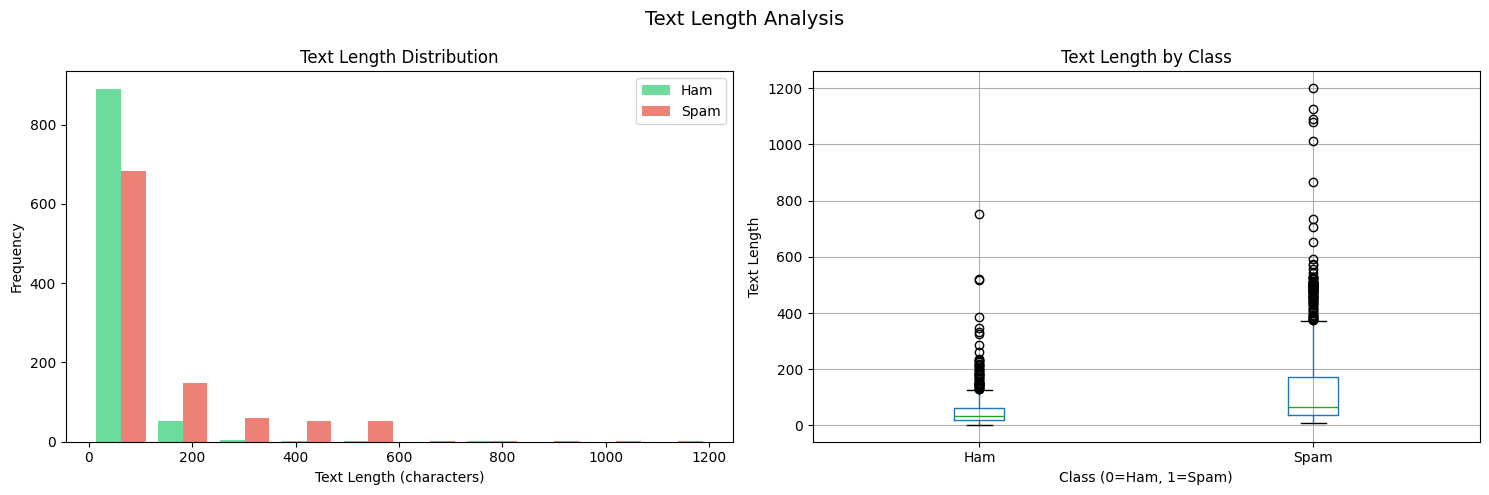

In [12]:
# Text length analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution
axes[0].hist(
    [df[df['CLASS'] == 0]['text_length'], df[df['CLASS'] == 1]['text_length']],
    label=['Ham', 'Spam'],
    color=['#2ecc71', '#e74c3c'],
    alpha=0.7,
)
axes[0].set_title('Text Length Distribution')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
df.boxplot(column='text_length', by='CLASS', ax=axes[1])
axes[1].set_title('Text Length by Class')
axes[1].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1].set_ylabel('Text Length')
plt.sca(axes[1])
plt.xticks([1, 2], ['Ham', 'Spam'])

fig.suptitle('Text Length Analysis', fontsize=14)

plt.tight_layout()
plt.show()

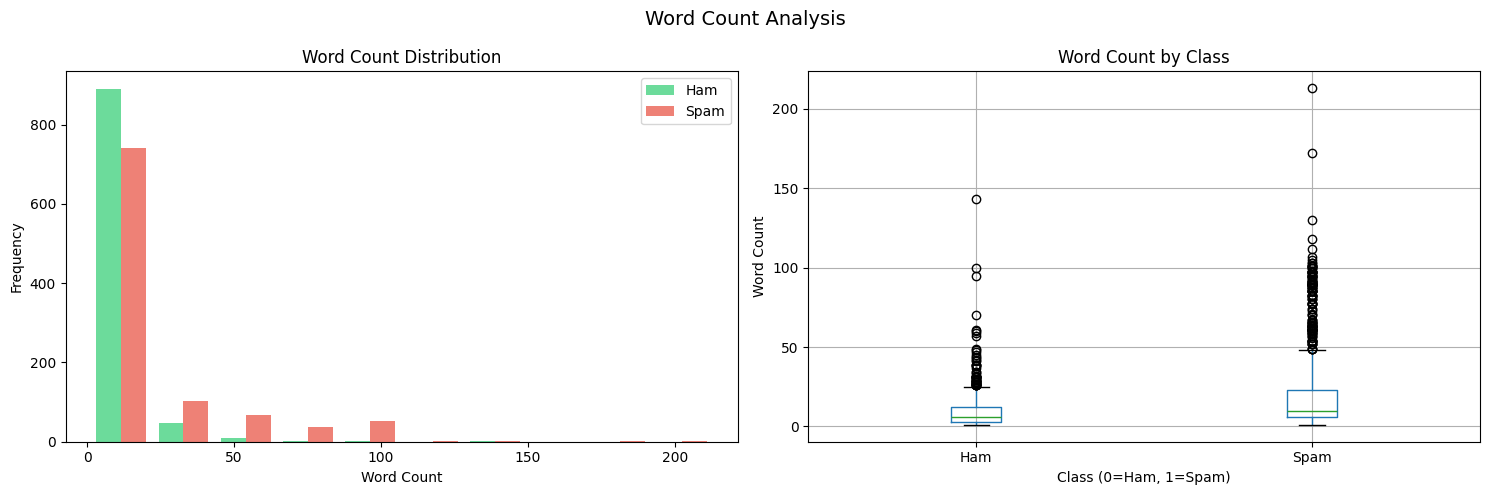

In [13]:
# Word count analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution
axes[0].hist(
    [df[df['CLASS'] == 0]['word_count'], df[df['CLASS'] == 1]['word_count']],
    label=['Ham', 'Spam'],
    color=['#2ecc71', '#e74c3c'],
    alpha=0.7,
)
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
df.boxplot(column='word_count', by='CLASS', ax=axes[1])
axes[1].set_title('Word Count by Class')
axes[1].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1].set_ylabel('Word Count')
plt.sca(axes[1])
plt.xticks([1, 2], ['Ham', 'Spam'])

fig.suptitle('Word Count Analysis', fontsize=14)

plt.tight_layout()
plt.show()

## Temporal Analysis


### Date Parsing and Feature Extraction


In [14]:
# Temporal Analysis Coverage
print('Temporal Analysis Coverage:')
print(f'- Total records: {len(df)}')
print(f'- Records with dates: {df["DATE"].notna().sum()}')
print(f'- Missing dates: {df["DATE"].isna().sum()} ({(df["DATE"].isna().sum()/len(df))*100:.1f}%)')
print(f'- Temporal patterns based on {df["DATE"].notna().sum()} records')

Temporal Analysis Coverage:
- Total records: 1956
- Records with dates: 1711
- Missing dates: 245 (12.5%)
- Temporal patterns based on 1711 records


In [15]:
# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='ISO8601', errors='coerce')
df['date_only'] = df['DATE'].dt.date
df['hour'] = df['DATE'].dt.hour
df['day_of_week'] = df['DATE'].dt.day_name()

print('Date Range:')
print(f'From: {df["DATE"].min()}')
print(f'To: {df["DATE"].max()}')
print(f'Duration: {(df["DATE"].max() - df["DATE"].min()).days} days')

# Check for any parsing errors
null_dates = df['DATE'].isnull().sum()
if null_dates > 0:
    print()
    print(f'Warning: {null_dates} dates could not be parsed')

Date Range:
From: 2013-07-12 22:33:27.916000
To: 2015-06-05 20:01:23
Duration: 692 days



### Temporal Patterns


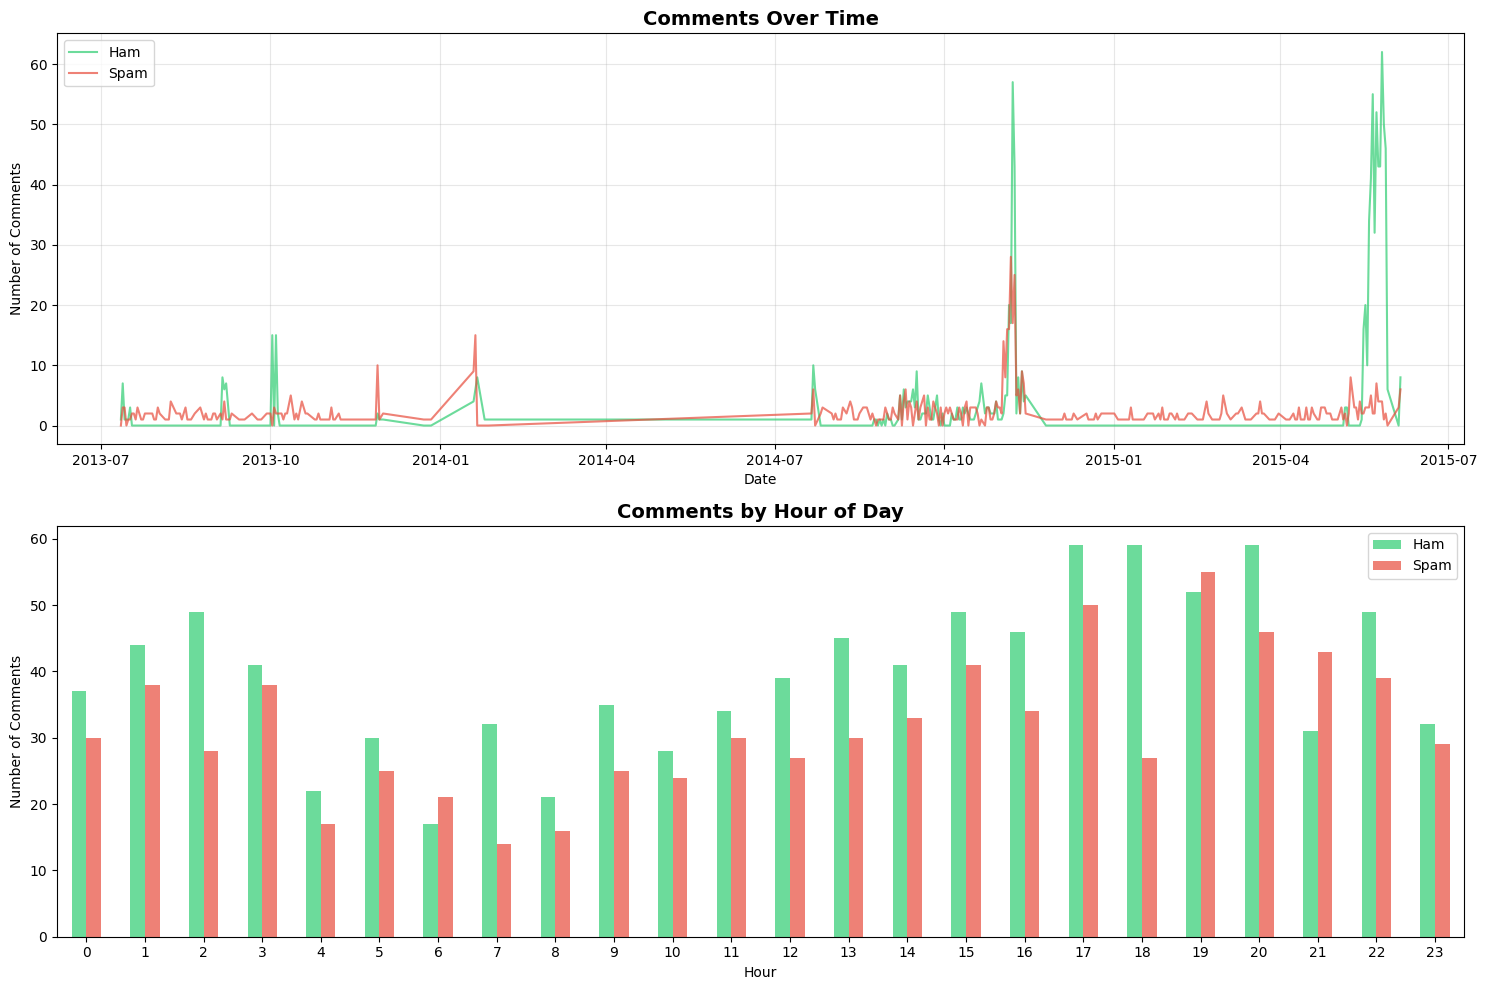

In [16]:
# Comments over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Comments by date
comments_by_date = df.groupby(['date_only', 'CLASS']).size().unstack(fill_value=0)
comments_by_date.plot(ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_title('Comments Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Comments')
axes[0].legend(['Ham', 'Spam'])
axes[0].grid(True, alpha=0.3)

# Comments by hour
comments_by_hour = df.groupby(['hour', 'CLASS']).size().unstack(fill_value=0)
comments_by_hour.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1].set_title('Comments by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Comments')
axes[1].legend(['Ham', 'Spam'])
axes[1].set_xticklabels(range(24), rotation=0)

plt.tight_layout()
plt.show()

## Author Analysis


### Author Statistics


In [17]:
# Top authors
print('Total unique authors:', df['AUTHOR'].nunique())
print()

print('Top 10 Most Active Authors:')
df['AUTHOR'].value_counts().head(10)

Total unique authors: 1792

Top 10 Most Active Authors:


AUTHOR
M.E.S              8
5000palo           7
Louis Bryant       7
Shadrach Grentz    7
DanteBTV           6
Derek Moya         5
Hidden Love        5
LuckyMusiqLive     5
James Cook         4
Scott Johnson      4
Name: count, dtype: int64

### Top Authors by Class


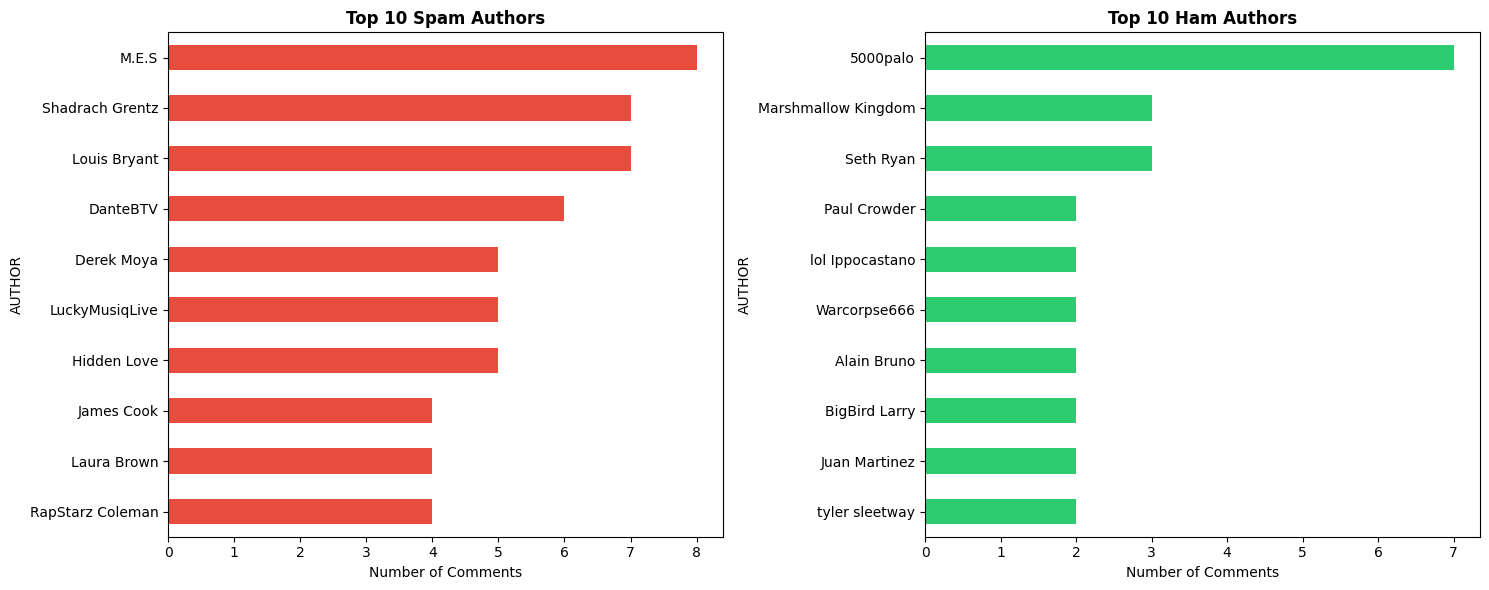

In [18]:
# Authors by class
spam_authors = df[df['CLASS'] == 1]['AUTHOR'].value_counts().head(10)
ham_authors = df[df['CLASS'] == 0]['AUTHOR'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

spam_authors.plot(kind='barh', ax=axes[0], color='#e74c3c')
axes[0].set_title('Top 10 Spam Authors', fontweight='bold')
axes[0].set_xlabel('Number of Comments')
axes[0].invert_yaxis()

ham_authors.plot(kind='barh', ax=axes[1], color='#2ecc71')
axes[1].set_title('Top 10 Ham Authors', fontweight='bold')
axes[1].set_xlabel('Number of Comments')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Text Content Analysis


### Common Words


In [19]:
def get_top_words(texts, n=20, min_length=3):
    """Extract top n most common words from texts"""
    # Combine all texts
    all_text = ' '.join(texts.astype(str))
    # Convert to lowercase and extract words
    words = re.findall(r'\b[a-z]+\b', all_text.lower())
    # Filter by length
    words = [w for w in words if len(w) >= min_length]
    # Count and return top n
    return Counter(words).most_common(n)

In [20]:
# Get top words for spam comments
spam_words = get_top_words(df[df['CLASS'] == 1]['CONTENT'], n=20)

print('Top 20 Words in SPAM Comments:')
for word, count in spam_words:
    print(f'{word:20s} {count:5d}')

Top 20 Words in SPAM Comments:
out                    571
check                  559
you                    509
and                    507
the                    440
this                   437
com                    296
please                 246
youtube                235
subscribe              229
video                  229
for                    219
channel                197
like                   160
can                    139
http                   136
amp                    130
just                   128
www                    125
new                    119


In [21]:
# Get top words for ham comments
ham_words = get_top_words(df[df['CLASS'] == 0]['CONTENT'], n=20)

print('\nTop 20 Words in HAM Comments:')
for word, count in ham_words:
    print(f'{word:20s} {count:5d}')


Top 20 Words in HAM Comments:
this                   301
the                    283
song                   224
love                   145
and                    136
you                    105
like                    90
views                   87
video                   84
that                    82
she                     65
best                    57
katy                    56
billion                 51
are                     48
good                    48
for                     45
just                    44
perry                   43
was                     42


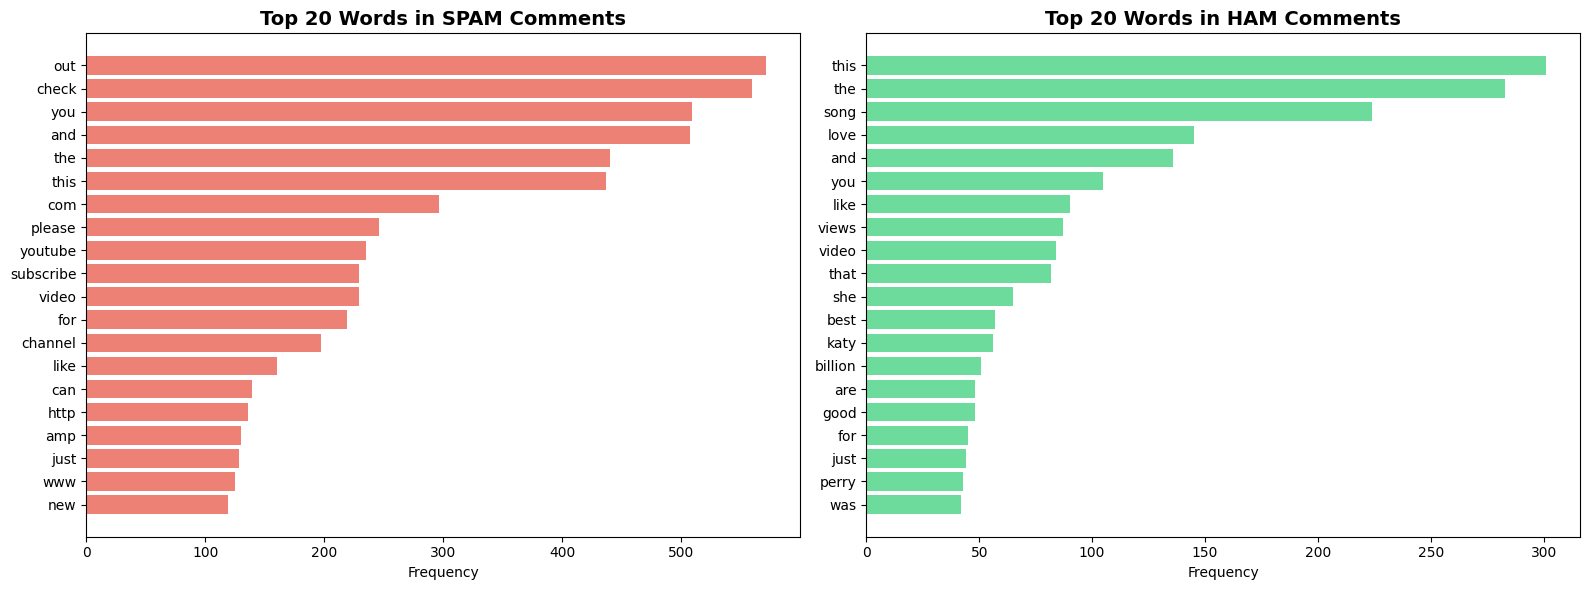

In [22]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Spam words
spam_df = pd.DataFrame(spam_words, columns=['word', 'count'])
axes[0].barh(spam_df['word'], spam_df['count'], color='#e74c3c', alpha=0.7)
axes[0].set_title('Top 20 Words in SPAM Comments', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Ham words
ham_df = pd.DataFrame(ham_words, columns=['word', 'count'])
axes[1].barh(ham_df['word'], ham_df['count'], color='#2ecc71', alpha=0.7)
axes[1].set_title('Top 20 Words in HAM Comments', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Feature Correlations


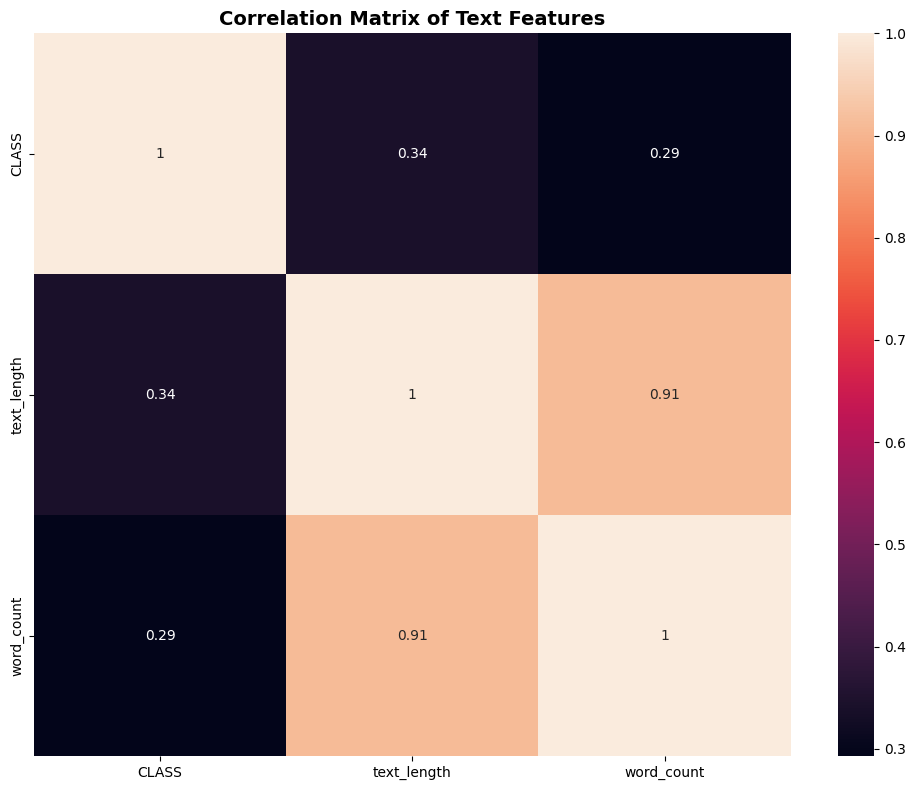

In [23]:
# Correlation matrix for text features
correlation_matrix = df[['CLASS', 'text_length', 'word_count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)

plt.title('Correlation Matrix of Text Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## Summary


In [24]:
print(f'1. Dataset Size: {len(df)} comments')
print(f'   - Spam: {(df["CLASS"] == 1).sum()} ({(df["CLASS"] == 1).sum() / len(df) * 100:.1f}%)')
print(f'   - Ham: {(df["CLASS"] == 0).sum()} ({(df["CLASS"] == 0).sum() / len(df) * 100:.1f}%)')
print()

print('2. Data Quality:')
print(f'   - Missing values: {df.isnull().sum().sum()}')
print(f'   - Duplicate rows: {df.duplicated().sum()}')
print(f'   - Duplicate content: {df["CONTENT"].duplicated().sum()}')
print(f'   - Missing dates: {df["DATE"].isna().sum()} ({(df["DATE"].isna().sum()/len(df))*100:.1f}%)')
print()

print('3. Text Characteristics:')
print(f'   - Average text length (Spam): {df[df["CLASS"] == 1]["text_length"].mean():.1f} chars')
print(f'   - Average text length (Ham): {df[df["CLASS"] == 0]["text_length"].mean():.1f} chars')
print(f'   - Average word count (Spam): {df[df["CLASS"] == 1]["word_count"].mean():.1f} words')
print(f'   - Average word count (Ham): {df[df["CLASS"] == 0]["word_count"].mean():.1f} words')
print()

print('4. Temporal Information:')
print(f'   - Date range: {df["DATE"].min().date()} to {df["DATE"].max().date()}')
print(f'   - Total unique authors: {df["AUTHOR"].nunique()}')
print()

print('5. Feature Correlations with CLASS:')
correlations = (
    df[['CLASS', 'text_length', 'word_count']]
    .corr()['CLASS']
    .sort_values(ascending=False)[1:]
)
for feature, corr in correlations.items():
    print(f'   - {feature}: {corr:.3f}')

1. Dataset Size: 1956 comments
   - Spam: 1005 (51.4%)
   - Ham: 951 (48.6%)

2. Data Quality:
   - Missing values: 980
   - Duplicate rows: 3
   - Duplicate content: 196
   - Missing dates: 245 (12.5%)

3. Text Characteristics:
   - Average text length (Spam): 137.3 chars
   - Average text length (Ham): 49.6 chars
   - Average word count (Spam): 21.7 words
   - Average word count (Ham): 9.1 words

4. Temporal Information:
   - Date range: 2013-07-12 to 2015-06-05
   - Total unique authors: 1792

5. Feature Correlations with CLASS:
   - text_length: 0.342
   - word_count: 0.293
